In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf

**Dataset_Loading**

In [ ]:
train_data = pd.read_csv('/content/trainEmotions.csv')
test_data = pd.read_csv('/content/testEmotions.csv')


In [ ]:
train_data

,emotion,content
0,happiness,victory for the bulldogs was celebrated by 3 w...
1,happiness,"@saraLDS Thanks for that, Sara"
2,happiness,@Tony_Mandarich well welcome back from the dar...
3,happiness,"@sai_shediddy lol , you gotta share too"
4,happiness,"first up, make up for lost time with jelly. Ja..."
...,...,...
14499,neutral,Wish I lived in or atleast relatively close to...
14500,neutral,@3Gguy and within a short time of the last clu...
14501,neutral,my phone still doesnt tweet
14502,neutral,"@blindcripple Good idea Brain, you can't not b..."


In [ ]:
train_data

,emotion,content
0,happiness,victory for the bulldogs was celebrated by 3 w...
1,happiness,"@saraLDS Thanks for that, Sara"
2,happiness,@Tony_Mandarich well welcome back from the dar...
3,happiness,"@sai_shediddy lol , you gotta share too"
4,happiness,"first up, make up for lost time with jelly. Ja..."
...,...,...
14499,neutral,Wish I lived in or atleast relatively close to...
14500,neutral,@3Gguy and within a short time of the last clu...
14501,neutral,my phone still doesnt tweet
14502,neutral,"@blindcripple Good idea Brain, you can't not b..."


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Data Cleaning and Preprocessing**

In [ ]:
# Text Cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NUMBERS = re.compile('\d+')

STOPWORDS = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[@#][A-Za-z0-9_]+|\w+:\/\/\S+", "", text)  # Remove mentions and hashtags
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)  # Replace certain characters with space
    text = re.sub(BAD_SYMBOLS_RE, '', text)  # Remove bad symbols
    text = re.sub(NUMBERS, '', text)  # Remove numbers
    text = tf.strings.regex_replace(text, '[\d+]', '')  # Remove numbers using TensorFlow
    text = tf.strings.lower(text)  # Convert text to lowercase using TensorFlow
    text = tf.strings.regex_replace(text, '[^a-zA-Z]', ' ')  # Remove special characters using TensorFlow
    text = tf.strings.regex_replace(text, '\s+', ' ')  # Remove extra spaces using TensorFlow
    return text


In [ ]:
train_data['cleaned_content'] = train_data['content'].apply(clean_text)
test_data['cleaned_content'] = test_data['content'].apply(clean_text)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Import the WordNetLemmatizer class
from nltk.stem import WordNetLemmatizer

# Tokenization
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize_tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in nltk.corpus.stopwords.words('english')]
    return tokens

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print(train_data['cleaned_content'].dtype)

object


In [ ]:
train_data['cleaned_content'] = train_data['cleaned_content'].astype(str)
test_data['cleaned_content'] = test_data['cleaned_content'].astype(str)

In [ ]:
train_data['tokens'] = train_data['cleaned_content'].apply(lemmatize_tokenize)
test_data['tokens'] = test_data['cleaned_content'].apply(lemmatize_tokenize)

**Exploratory Data Analysis EDA**

In [ ]:
#Exploratory Data Analysis (EDA)
print(train_data.head())
print(train_data.info())
print(train_data['emotion'].value_counts())

     emotion                                            content  \
0  happiness  victory for the bulldogs was celebrated by 3 w...   
1  happiness                     @saraLDS Thanks for that, Sara   
2  happiness  @Tony_Mandarich well welcome back from the dar...   
3  happiness            @sai_shediddy lol , you gotta share too   
4  happiness  first up, make up for lost time with jelly. Ja...   

                                     cleaned_content  \
0  b'victory for the bulldogs was celebrated by w...   
1                           b' thanks for that sara'   
2           b' well welcome back from the dark side'   
3                        b' lol you gotta share too'   
4  b'first up make up for lost time with jelly ja...   

                                              tokens  
0  [b'victory, bulldog, celebrated, white, chocol...  
1                            [b, ', thanks, sara, ']  
2         [b, ', well, welcome, back, dark, side, ']  
3                     [b, ', lol, got, t

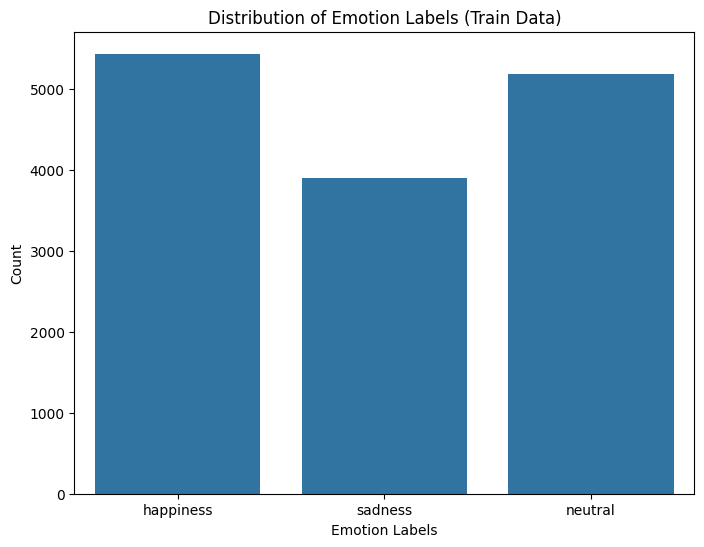

In [ ]:
# Plot distribution of target labels
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion', data=train_data)
plt.title('Distribution of Emotion Labels (Train Data)')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.show()

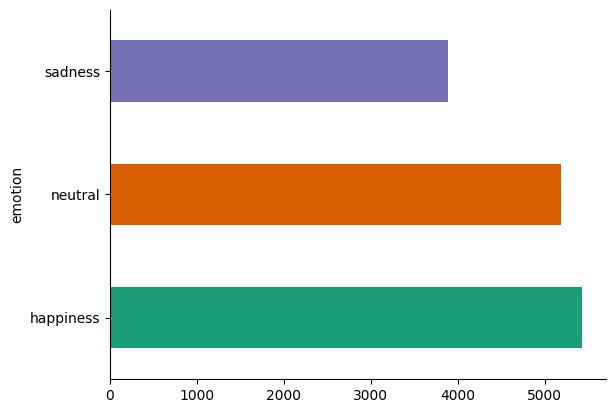

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train_data.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

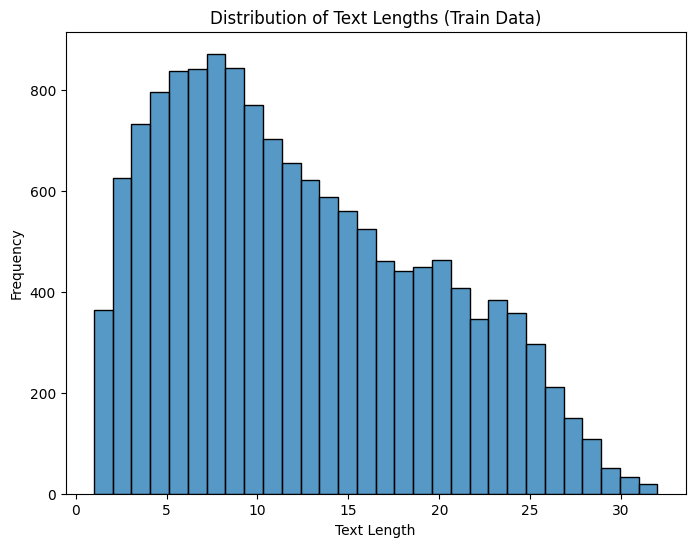

In [ ]:
# Visualize distribution of text lengths

texts_train = train_data['content'].values
text_lengths_train = [len(text.split()) for text in texts_train]
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths_train, bins=30)
plt.title('Distribution of Text Lengths (Train Data)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

**Preprocessing_Encoding_labels**

In [ ]:
#Preprocessing
# Encode labels
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(train_data['emotion'].values)
encoded_labels_test = label_encoder.transform(test_data['emotion'].values)


In [ ]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tokens'].values)
sequences_train = tokenizer.texts_to_sequences(train_data['tokens'].values)
sequences_test = tokenizer.texts_to_sequences(test_data['tokens'].values)

In [ ]:
# Pad sequences
max_len = max([len(seq) for seq in sequences_train + sequences_test])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_len, padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')


### Data Cleaning and Processing Pipeline Explanation

#### Data Cleaning:
1. **Lowercasing**: The text data is converted to lowercase to ensure uniformity in text processing and analysis.
   
2. **URL Removal**: Regular expressions are used to remove URLs from the text data as they typically don't contribute to sentiment or emotion analysis.

3. **Mention and Hashtag Removal**: Using regex, mentions (e.g., @username) and hashtags (#example) are removed from the text data as they often do not provide valuable information for emotion classification.

4. **Special Character Removal**: Certain special characters such as parentheses, brackets, etc., are removed using regex to ensure that the text data is clean and ready for analysis.

5. **Numeric Removal**: Numbers are removed from the text data as they may not be relevant for emotion classification and can add noise to the data.

6. **Stopword Removal**: Stopwords (commonly occurring words like 'the', 'is', 'and', etc.) are removed from the text data as they typically do not carry significant meaning for emotion classification.

7. **Lemmatization**: The text is tokenized and lemmatized using NLTK's WordNetLemmatizer to reduce words to their base or dictionary form. This helps in standardizing the text data further.

#### Data Preprocessing:
1. **Tokenization**: The cleaned text data is tokenized into individual words using NLTK's word_tokenize function. This breaks down the text into its constituent words for further processing.

2. **Lemmatization and Stopword Removal**: Tokenized words are lemmatized to reduce them to their base form, and stopwords are removed to eliminate noise from the text data.

3. **Encoding Labels**: Emotion labels are encoded using scikit-learn's LabelEncoder to convert categorical emotion labels into numerical values for model training.

4. **Text Tokenization**: The text data is tokenized using Keras' Tokenizer, which converts text into sequences of integers, where each integer represents a unique word in the vocabulary.

5. **Padding Sequences**: To ensure uniform input dimensions for the model, sequences are padded or truncated to a fixed length using Keras' pad_sequences function. This ensures that all sequences have the same length, which is crucial for training deep learning models.

#### Exploratory Data Analysis (EDA):
1. **Data Summary**: A summary of the dataset including the first few rows, information about columns, and counts of unique emotion labels is provided to understand the structure and composition of the data.

2. **Label Distribution Visualization**: The distribution of emotion labels in the dataset is visualized using count plots to understand the class balance or imbalance.

3. **Text Length Distribution**: The distribution of text lengths is visualized to understand the variability in text lengths across the dataset. This helps in determining an appropriate maximum sequence length for padding sequences during preprocessing.

Overall, this pipeline ensures that the text data is cleaned, processed, and prepared in a standardized format suitable for emotion classification tasks, while EDA provides insights into the dataset's characteristics and helps in making informed decisions during model development and evaluation.


In [ ]:
# Step 4: Train-Test Split (using train data only for EDA)
X_train, X_val, y_train, y_val = train_test_split(padded_sequences_train, encoded_labels_train, test_size=0.2, random_state=42)


**LSTM Model**

In [ ]:
# Define LSTM model
def create_lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim + 1, output_dim=100, input_length=max_len))
    model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
    return model


**GRU Model**

In [ ]:
# Define GRU model
def create_gru_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim + 1, output_dim=100, input_length=max_len))
    model.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
    return model


**Training Model**

In [ ]:
# Compile and train models
def compile_and_train(model, optimizer, X_train, y_train, X_val, y_val):
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    return history



**Evaluate model on test set and plot confusion matrix**


In [ ]:
# Evaluate model on test set and plot confusion matrix
def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_percentage = accuracy * 100  # Convert accuracy to percentage
    print("Accuracy: {:.2f}%".format(accuracy_percentage))  # Print accuracy as percentage
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



**LSTM Training**

Epoch 1/20
363/363 [==============================] - 47s 116ms/step - loss: 1.0353 - accuracy: 0.4256 - val_loss: 0.9467 - val_accuracy: 0.5353
Epoch 2/20
363/363 [==============================] - 35s 97ms/step - loss: 0.8588 - accuracy: 0.5948 - val_loss: 0.8535 - val_accuracy: 0.6039
Epoch 3/20
363/363 [==============================] - 36s 98ms/step - loss: 0.7560 - accuracy: 0.6781 - val_loss: 0.8458 - val_accuracy: 0.6312
Epoch 4/20
363/363 [==============================] - 34s 93ms/step - loss: 0.6766 - accuracy: 0.7256 - val_loss: 0.8611 - val_accuracy: 0.6212
Epoch 5/20
363/363 [==============================] - 34s 93ms/step - loss: 0.6117 - accuracy: 0.7658 - val_loss: 0.8914 - val_accuracy: 0.6194
Epoch 6/20
152/152 [==============================] - 2s 10ms/step
Accuracy: 51.09%
              precision    recall  f1-score   support

           0       0.77      0.32      0.45      1811
           1       0.48      0.59      0.53      1728
           2       0.44      0.6

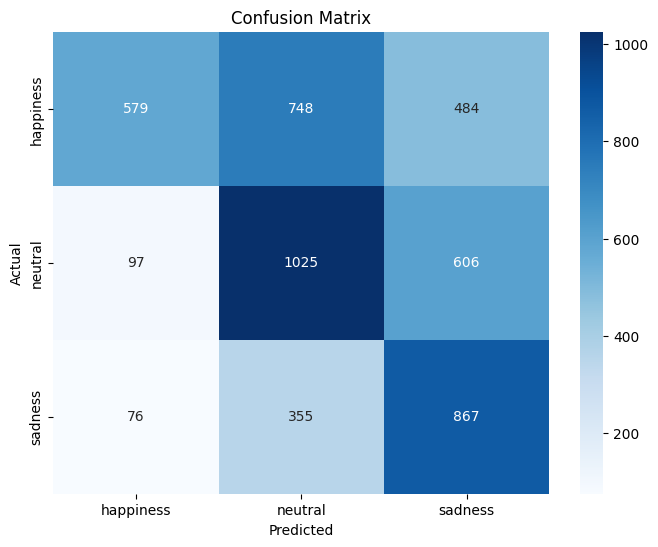

In [ ]:
!pip install scikit-learn
from sklearn.metrics import accuracy_score

# LSTM model
lstm_model = create_lstm_model(len(tokenizer.word_index))
lstm_history = compile_and_train(lstm_model, optimizer=RMSprop(), X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
evaluate_model(lstm_model, padded_sequences_test, encoded_labels_test)

**Vanilla RNN model Training**

Epoch 1/20
363/363 [==============================] - 41s 99ms/step - loss: 1.0914 - accuracy: 0.3756 - val_loss: 1.0906 - val_accuracy: 0.3792
Epoch 2/20
363/363 [==============================] - 30s 81ms/step - loss: 1.0895 - accuracy: 0.3728 - val_loss: 1.0911 - val_accuracy: 0.3519
Epoch 3/20
363/363 [==============================] - 28s 76ms/step - loss: 1.0897 - accuracy: 0.3675 - val_loss: 1.0882 - val_accuracy: 0.3792
Epoch 4/20
363/363 [==============================] - 28s 77ms/step - loss: 1.0895 - accuracy: 0.3684 - val_loss: 1.0883 - val_accuracy: 0.3792
Epoch 5/20
363/363 [==============================] - 29s 79ms/step - loss: 1.0893 - accuracy: 0.3718 - val_loss: 1.0888 - val_accuracy: 0.3788
Epoch 6/20
363/363 [==============================] - 28s 76ms/step - loss: 1.0892 - accuracy: 0.3735 - val_loss: 1.0881 - val_accuracy: 0.3792
Epoch 7/20
363/363 [==============================] - 28s 77ms/step - loss: 1.0866 - accuracy: 0.3688 - val_loss: 1.0680 - val_accuracy:

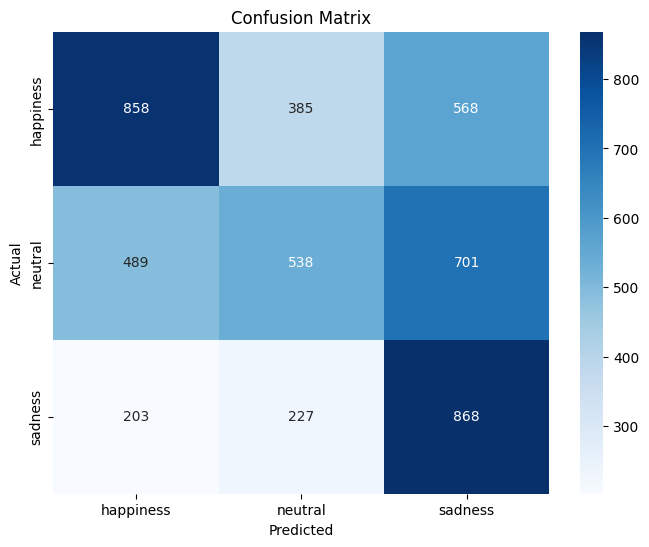

In [ ]:
from tensorflow.keras.layers import Dropout

# Define an enhanced Vanilla RNN model with increased complexity and regularization
def create_vanilla_rnn_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim + 1, output_dim=100, input_length=max_len))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(SimpleRNN(units=64, activation='relu', return_sequences=True))  # Added another RNN layer
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(SimpleRNN(units=32, activation='relu'))  # Added another RNN layer
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
    return model

# Compile and train the updated Vanilla RNN model with adjusted learning rate and increased epochs
vanilla_rnn_model = create_vanilla_rnn_model(len(tokenizer.word_index))
vanilla_rnn_history = compile_and_train(vanilla_rnn_model, optimizer=Adam(learning_rate=0.0001), X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
evaluate_model(vanilla_rnn_model, padded_sequences_test, encoded_labels_test)


**GRU Model Training**

Epoch 1/20
363/363 [==============================] - 65s 170ms/step - loss: 1.0911 - accuracy: 0.3571 - val_loss: 1.0894 - val_accuracy: 0.3540
Epoch 2/20
363/363 [==============================] - 33s 90ms/step - loss: 1.0307 - accuracy: 0.4261 - val_loss: 0.8926 - val_accuracy: 0.5832
Epoch 3/20
363/363 [==============================] - 33s 90ms/step - loss: 0.7781 - accuracy: 0.6532 - val_loss: 0.8193 - val_accuracy: 0.6425
Epoch 4/20
363/363 [==============================] - 31s 85ms/step - loss: 0.5607 - accuracy: 0.7775 - val_loss: 0.8849 - val_accuracy: 0.6350
Epoch 5/20
363/363 [==============================] - 31s 85ms/step - loss: 0.3843 - accuracy: 0.8608 - val_loss: 1.0846 - val_accuracy: 0.6153
Epoch 6/20
152/152 [==============================] - 1s 8ms/step
Accuracy: 53.86%
              precision    recall  f1-score   support

           0       0.72      0.42      0.53      1811
           1       0.55      0.56      0.55      1728
           2       0.44      0.68

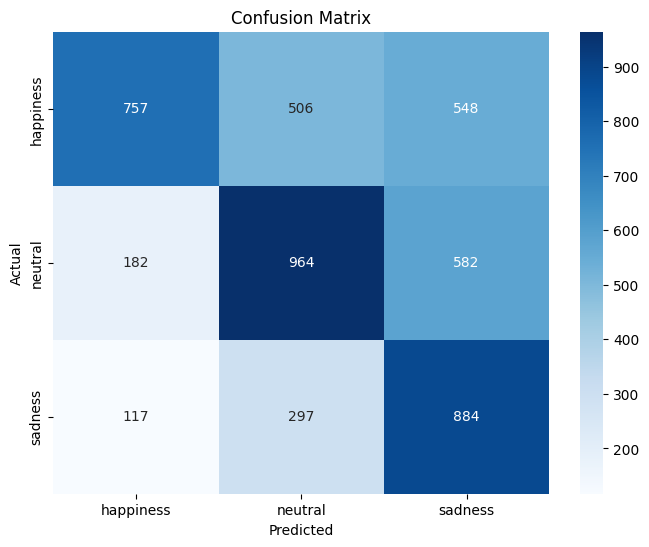

In [ ]:
# GRU model
gru_model = create_gru_model(len(tokenizer.word_index))
gru_history = compile_and_train(gru_model, optimizer=Adam(), X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
evaluate_model(gru_model, padded_sequences_test, encoded_labels_test)

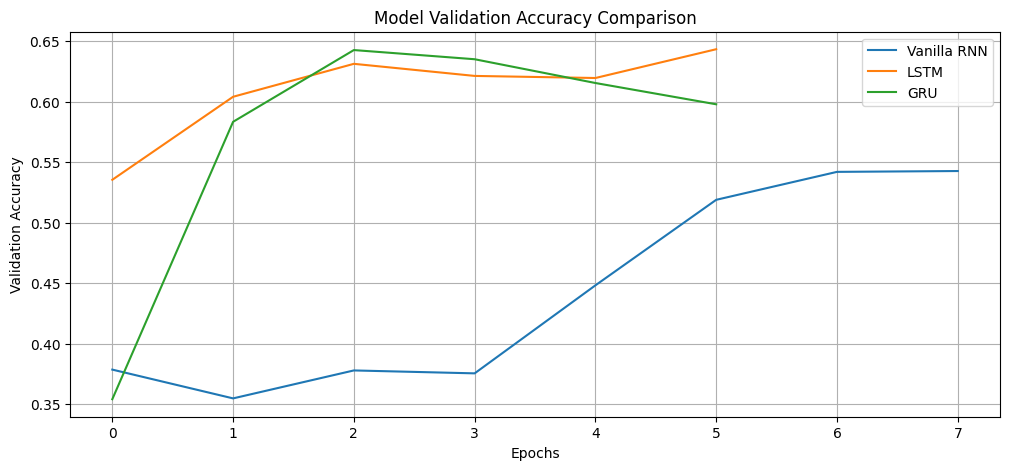

In [ ]:
# Plot accuracy for all models
plt.figure(figsize=(12, 5))
plt.plot(vanilla_rnn_history.history['val_accuracy'], label='Vanilla RNN')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
plt.plot(gru_history.history['val_accuracy'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Differences in Methods Tried

#### LSTM Model:
- **Architecture**: Long Short-Term Memory (LSTM) networks were utilized, which are a type of recurrent neural network (RNN) capable of learning long-term dependencies.
- **Dropout**: Dropout regularization was applied to prevent overfitting, with a dropout rate of 0.2 to randomly drop 20% of units during training.
- **Optimizer**: RMSprop optimizer was chosen for training the LSTM model.

#### Vanilla RNN Model:
- **Architecture**: A basic Vanilla RNN model was implemented with multiple recurrent layers to increase complexity.
- **Dropout**: Dropout regularization was applied after each recurrent layer with a dropout rate of 0.5.
- **Optimizer**: Adam optimizer was utilized with a learning rate of 0.0001 for training the Vanilla RNN model.

#### GRU Model:
- **Architecture**: Gated Recurrent Unit (GRU) networks were employed, which are similar to LSTMs but have fewer parameters.
- **Dropout**: Dropout regularization was applied to the GRU model with a dropout rate of 0.2.
- **Optimizer**: Adam optimizer was used for training the GRU model.

#### Observations and Differences:
- **Complexity**: LSTM and GRU models typically have more parameters and are capable of capturing long-term dependencies more effectively compared to Vanilla RNNs.
- **Regularization**: Dropout regularization was applied to all models to prevent overfitting, although the dropout rates varied between models.
- **Optimizers**: Different optimizers were used for training each model, with RMSprop for LSTM, Adam with a specific learning rate for Vanilla RNN, and Adam for GRU. Optimizer choice can affect convergence speed and performance.




### Conclusion

In this project, we explored various deep learning architectures for emotion classification using text data. We experimented with Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU), and Vanilla Recurrent Neural Network (RNN) models. Here are the key takeaways:

- **Model Architectures**: We implemented LSTM, GRU, and Vanilla RNN architectures to capture the sequential nature of text data and learn patterns related to emotions.
- **Regularization**: Dropout regularization was applied to prevent overfitting in all models. Different dropout rates were used for each model to find the optimal balance between performance and generalization.
- **Optimizers**: We employed RMSprop for LSTM, Adam with a specific learning rate for Vanilla RNN, and Adam for GRU. Optimizer choice can significantly impact model convergence and performance.
- **Evaluation**: Each model was evaluated on the test set using accuracy, precision, recall, and F1-score metrics. Confusion matrices were also plotted to visualize the performance of each model across different emotion classes.
- **Performance Comparison**: The performance of each model varied, with LSTM and GRU generally outperforming Vanilla RNN. However, the choice of the best model depends on the specific dataset and task requirements.

In conclusion, through experimentation with different architectures and optimization strategies, we gained insights into building effective deep learning models for emotion classification tasks. Further fine-tuning and hyperparameter optimization could lead to even better performance on the task at hand.
